In [1]:
# imports

import sys, os
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import IPython
from IPython.display import display
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)


In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_collection.models import Agents

In [3]:
# read data

vct_2023_path = Path('./../out/vct_2023').resolve()

teams = pd.read_csv(vct_2023_path / 'teams.csv')
players = pd.read_csv(vct_2023_path / 'players.csv')
matches = pd.read_csv(vct_2023_path / 'matches.csv')
map_player_stats = pd.read_csv(vct_2023_path / 'stats_maps.csv')


In [4]:
# get matces with participating teams

matches_with_teams = matches.set_index('TeamAID').join(teams.set_index('ID'), rsuffix='A')
matches_with_teams = matches_with_teams.reset_index().set_index('TeamBID').join(teams.set_index('ID'), rsuffix='B')
matches_with_teams = matches_with_teams.reset_index().drop(columns=['Completed', 'WinnerID'])

display(matches_with_teams[-10:-1])

,TeamBID,TeamAID,ID,EventID,Name,NameB
321,12010,12685,235556,1664,Trace Esports,Bilibili Gaming
322,12011,1211,221841,1664,Totoro Gaming,Douyu Gaming
323,12011,4460,219596,1664,Number One Player,Douyu Gaming
324,12011,5944,221179,1664,Night Wings Gaming,Douyu Gaming
325,12011,11981,222532,1664,Dragon Ranger Gaming,Douyu Gaming
326,12064,804,221838,1664,Royal Never Give Up,Nova Esports
327,12064,4683,219597,1664,Invincible Gaming,Nova Esports
328,12202,5944,221839,1664,Night Wings Gaming,Gank Gaming
329,12202,12064,222368,1664,Nova Esports,Gank Gaming


In [5]:
# get player agent played per map

mpswt = matches_with_teams.set_index('ID').join(map_player_stats.set_index('ID'))
mpswt['TeamName'] = np.where(mpswt['TeamOrder'] == 1, mpswt['NameB'], mpswt['Name'])
player_stats_per_map = mpswt.reset_index().drop(columns=['EventID', 'Order', 'TeamOrder', 'TeamBID', 'TeamAID', 'Name', 'NameB', 'ID'])
player_stats_per_map = player_stats_per_map.set_index('PlayerID').join(players.set_index('ID')).reset_index()
player_stats_per_map = player_stats_per_map.rename(columns={'PlayerID': 'ID', 'TeamName': 'Team', 'Tag': 'Player'})[['ID', 'Team', 'Player', 'Agent']]

display(player_stats_per_map)

,ID,Team,Player,Agent
0,4,NRG Esports,crashies,SOVA
1,4,NRG Esports,crashies,SOVA
2,4,NRG Esports,crashies,SOVA
3,4,NRG Esports,crashies,SOVA
4,4,NRG Esports,crashies,SOVA
...,...,...,...,...
8295,39494,Rare Atom,Yueluo,SKYE
8296,39494,Rare Atom,Yueluo,SKYE
8297,39494,Rare Atom,Yueluo,SKYE
8298,39522,Nova Esports,DanGe,SAGE


In [6]:
# get agent playrate

key = ['Team', 'Player']
player_agent_playrate = player_stats_per_map.groupby(['Team', 'Player', 'ID', 'Agent'], group_keys=False).size()
player_agent_playrate = player_agent_playrate.groupby(['Team', 'Player', 'ID'], group_keys=False).apply(lambda x: x / x.sum()).to_frame()
player_agent_playrate = player_agent_playrate.reset_index().rename(columns={0: 'Percent'}).set_index(['Team', 'Player'])

display(player_agent_playrate.loc['100 Thieves', 'Asuna'])

ID   Agent   Percent
Team        Player                       
100 Thieves Asuna   601  BREACH  0.058824
            Asuna   601   GEKKO  0.088235
            Asuna   601    KAYO  0.235294
            Asuna   601    RAZE  0.147059
            Asuna   601    SAGE  0.147059
            Asuna   601    SKYE  0.294118
            Asuna   601    YORU  0.029412

In [7]:
agent_list = [str(e)[7:] for e in Agents]

player_agent_ndarray = player_agent_playrate.to_numpy()
agent_index = {x: i for i, x in enumerate([str(e)[7:] for e in Agents])}
agents_indexed = np.array([agent_index[x] for x in player_agent_ndarray[:,1]])
player_agent_ndarray[:,1] = agents_indexed

display(player_agent_ndarray)

array([[601, 2, 0.058823529411764705],
       [601, 8, 0.08823529411764706],
       [601, 11, 0.23529411764705882],
       ...,
       [1000, 18, 0.023255813953488372],
       [1000, 19, 0.16279069767441862],
       [1000, 20, 0.023255813953488372]], dtype=object)

In [8]:
datapoints_shape = (players.shape[0], len(agent_index))
player_datapoints = np.zeros(datapoints_shape)

i = 0

for row in player_datapoints:
    row[0] = player_agent_ndarray[i][0]

    while player_agent_ndarray[i][0] == row[0]:
        row[player_agent_ndarray[i][1]] = player_agent_ndarray[i][2]
        i += 1

display(player_datapoints[0])

array([601.        ,   0.        ,   0.05882353,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.08823529,   0.        ,   0.        ,   0.23529412,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.14705882,   0.        ,   0.14705882,   0.29411765,
         0.        ,   0.        ,   0.02941176])

## ACTUAL DATA ANALYSIS!!!

In [9]:
# kmeans, k = 15

kmeans_15_mastery = KMeans(n_clusters=15, n_init='auto').fit(player_datapoints[:,1:])

In [10]:
k_15_labels = kmeans_15_mastery.labels_
k_15_centers = kmeans_15_mastery.cluster_centers_

In [11]:
pca = PCA(3)
player_datapoints_vis = pca.fit_transform(player_datapoints[:,1:])

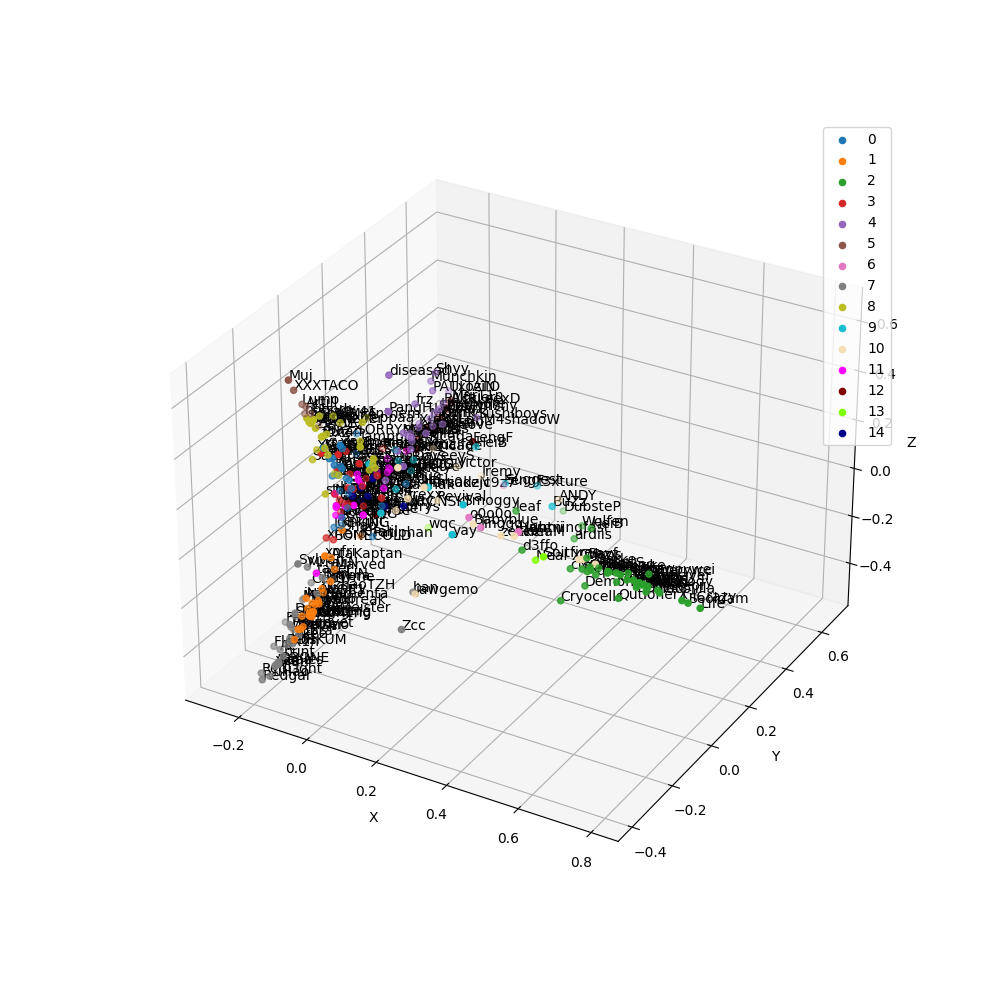

In [35]:
%matplotlib widget 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','wheat','magenta','maroon','chartreuse','darkblue','aqua','purple']

for i in range(15):
    xs = player_datapoints_vis[k_15_labels == i , 0]
    ys = player_datapoints_vis[k_15_labels == i , 1]
    zs = player_datapoints_vis[k_15_labels == i , 2]

    label = k_15_labels[k_15_labels == i].astype(float)
    
    ax.scatter(xs, ys, zs, label=i, c=colors[i])

for i in range(player_datapoints_vis.shape[0]):
    player_name = players.loc[int(player_datapoints[i,0])]['Tag']
    x = player_datapoints_vis[i, 0]
    y = player_datapoints_vis[i, 1]
    z = player_datapoints_vis[i, 2]
    
    ax.text(x, y, z, player_name)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend()
plt.show()

In [36]:
centers_labeled = {}
threshold = 0.0
sum_threshold = 0.5


for idx, center in enumerate(k_15_centers):
    centers_labeled[idx] = {}
    for i, percent in enumerate(center):
        if percent > threshold:
            centers_labeled[idx][agent_list[i + 1]] = percent 

    centers_labeled[idx] = dict(sorted(centers_labeled[idx].items(), key=lambda x: x[1], reverse=True))
    

    majority = []
    culm_sum = 0
    for agent, percent in centers_labeled[idx].items():
        if culm_sum < sum_threshold:
            majority.append(agent)
            culm_sum += percent
        else: break

    centers_labeled[idx] = {'top_agents': majority, ** centers_labeled[idx]}


print(json.dumps(centers_labeled, indent=4))

{
    "0": {
        "top_agents": [
            "BREACH",
            "KAYO"
        ],
        "BREACH": 0.4264393029116076,
        "KAYO": 0.1565667438736199,
        "SKYE": 0.1035234316829181,
        "VIPER": 0.05562016820505786,
        "SOVA": 0.04166892322134257,
        "ASTRA": 0.038880914407230203,
        "HARBOR": 0.03868214874793822,
        "FADE": 0.03410618279569892,
        "KILLJOY": 0.026826554411444076,
        "RAZE": 0.024607907027261844,
        "CYPHER": 0.016369047619047623,
        "OMEN": 0.016121553884711773,
        "SAGE": 0.010378787878787878,
        "JETT": 0.0042708333333333764,
        "NEON": 0.002604166666666668,
        "BRIMSTONE": 0.0016666666666666705,
        "GEKKO": 0.0016666666666666687,
        "YORU": 4.336808689942018e-19
    },
    "1": {
        "top_agents": [
            "ASTRA",
            "OMEN"
        ],
        "ASTRA": 0.307172305139651,
        "OMEN": 0.2906091325765185,
        "BRIMSTONE": 0.13458567249326417,
        "H

In [59]:
display(player_agent_playrate.reset_index().set_index('Player').loc['d4v41'])


,Team,ID,Agent,Percent
Player,,,,
d4v41,Paper Rex,9803,FADE,0.016129
d4v41,Paper Rex,9803,KAYO,0.080645
d4v41,Paper Rex,9803,KILLJOY,0.145161
d4v41,Paper Rex,9803,SKYE,0.564516
d4v41,Paper Rex,9803,SOVA,0.016129
d4v41,Paper Rex,9803,VIPER,0.177419
